# Axon growth quantification

In [12]:
import napari
import numpy as np
from glob import glob
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.utils import *
import re

# add auto update of libraries
%load_ext autoreload
%autoreload 2

# viewer = napari.Viewer()

First of all, specify the name of a measurement and folder name.

In [4]:
print('what is the name of a measurement?')
name = input()
print('where is it located?')
folder_name = input()

what is the name of a measurement?
where is it located?


Next cell will open the swc files from the folder and save them in the readable for Python format. Be sure to correctly specify the folder name! 

In [5]:
axons = read_axon(folder_name)
print('Number of time points is', len(axons))

Number of time points is 6


Next cell would shift origins of axons from different time points to the one point. 

In [6]:
shifted_axons = shift_axon(axons)
print('Axons from different time points were shifted to the same origin')

Axons from different time points were shifted to the same origin


Next cell will visualize all axons from different time points, each with unique color in the open Viewer.

In [7]:
# vizualize axons
for i, axon in enumerate(shifted_axons):
    color = np.random.rand(3) # generate new color
    viewer.add_shapes(axon, name=f'axon t ={i+1}', shape_type='path', ndim = 2, edge_width=1, edge_color=color, face_color=color)

/opt/miniconda3/envs/bioimage/lib/python3.9/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/opt/miniconda3/envs/bioimage/lib/python3.9/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/opt/miniconda3/envs/bioimage/lib/python3.9/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/opt/miniconda3/envs/bioimage/lib/python3.9/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all

In [8]:
# vizualize the growth
growth = np.array( [axon[-1] for axon in shifted_axons])
viewer.add_shapes(growth, name='growth path', shape_type='path', ndim = 2, edge_width=1, edge_color='green', face_color='green')
viewer.add_points(growth, size=1, face_color='green')

# save growth to csv
growth.tofile(f'growth_{name}.csv',sep=',',format='%10.5f')

/opt/miniconda3/envs/bioimage/lib/python3.9/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/opt/miniconda3/envs/bioimage/lib/python3.9/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


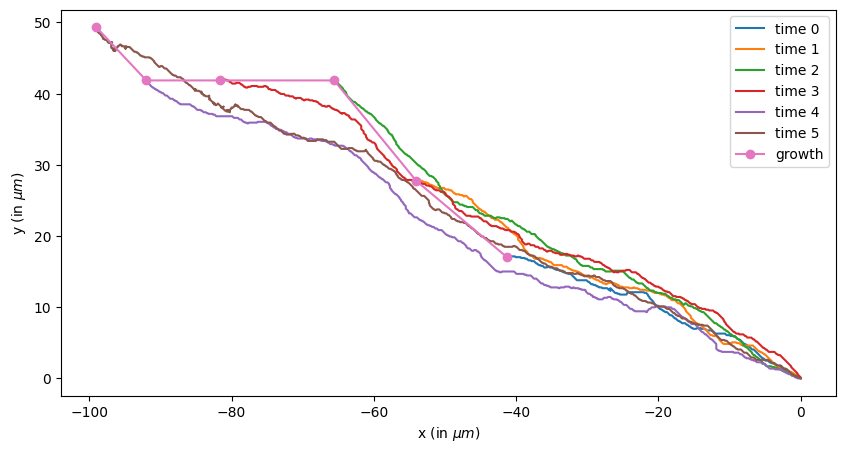

In [9]:
# use matplotlib to plot the axons
fig, ax = plt.figure(figsize=(10,10)), plt.axes()
for i, axon in enumerate(shifted_axons):
    ax.plot(axon[:,0], axon[:,1], label = 'time ' + str(i))
    
ax.plot(growth[:,0], growth[:,1], 'o-', label='growth')
ax.legend()
ax.set_aspect('equal')
# set x and y titles
ax.set_xlabel('x (in $\mu m$)')
ax.set_ylabel('y (in $\mu m$)')
plt.show()

The below cell would compute the required parameters for each time point.

In [20]:
# check if there is already a file with measurements
if os.path.isfile(f'measurements.csv'):
    measurements = pd.read_csv('measurements.csv')
    # create dictionary from the dataframe
    measurements = measurements.to_dict('list')
else:
    measurements = defaultdict(list) # set measurements dictionary

# set columns names 
columns = ['Name of a measurement', 'Time', 'Coordinate of the tip node', 'Axon length ($\mu m$)', 'Speed from $t_{i-1}$ to $t_{i}$ ($\mu m / \text{sec}$)',
        'Axon growth distance from $t_{i-1}$ to $t_{i}$ ($\mu m$)',  'Angle change from $t_{i-1}$ to $t_{i}$ (%)', 'Total growth during all time ($\mu m$)', 
        'Total speed during all time ($\mu m / \text{sec}$)', 'Total angle change (%)']

measurements = measure(growth, measurements, columns, name)
measurements = pd.DataFrame(measurements)
measurements.to_csv('measurements.csv', index=False)

/Users/septentrionalem/Desktop/Tavakoli2022/Tavakoli2022/utils/utils.py:86: RuntimeWarning: invalid value encountered in divide
  x = prev_prev_node - prev_node


Next cell is not compulsory and can be used to visualize the computed data.

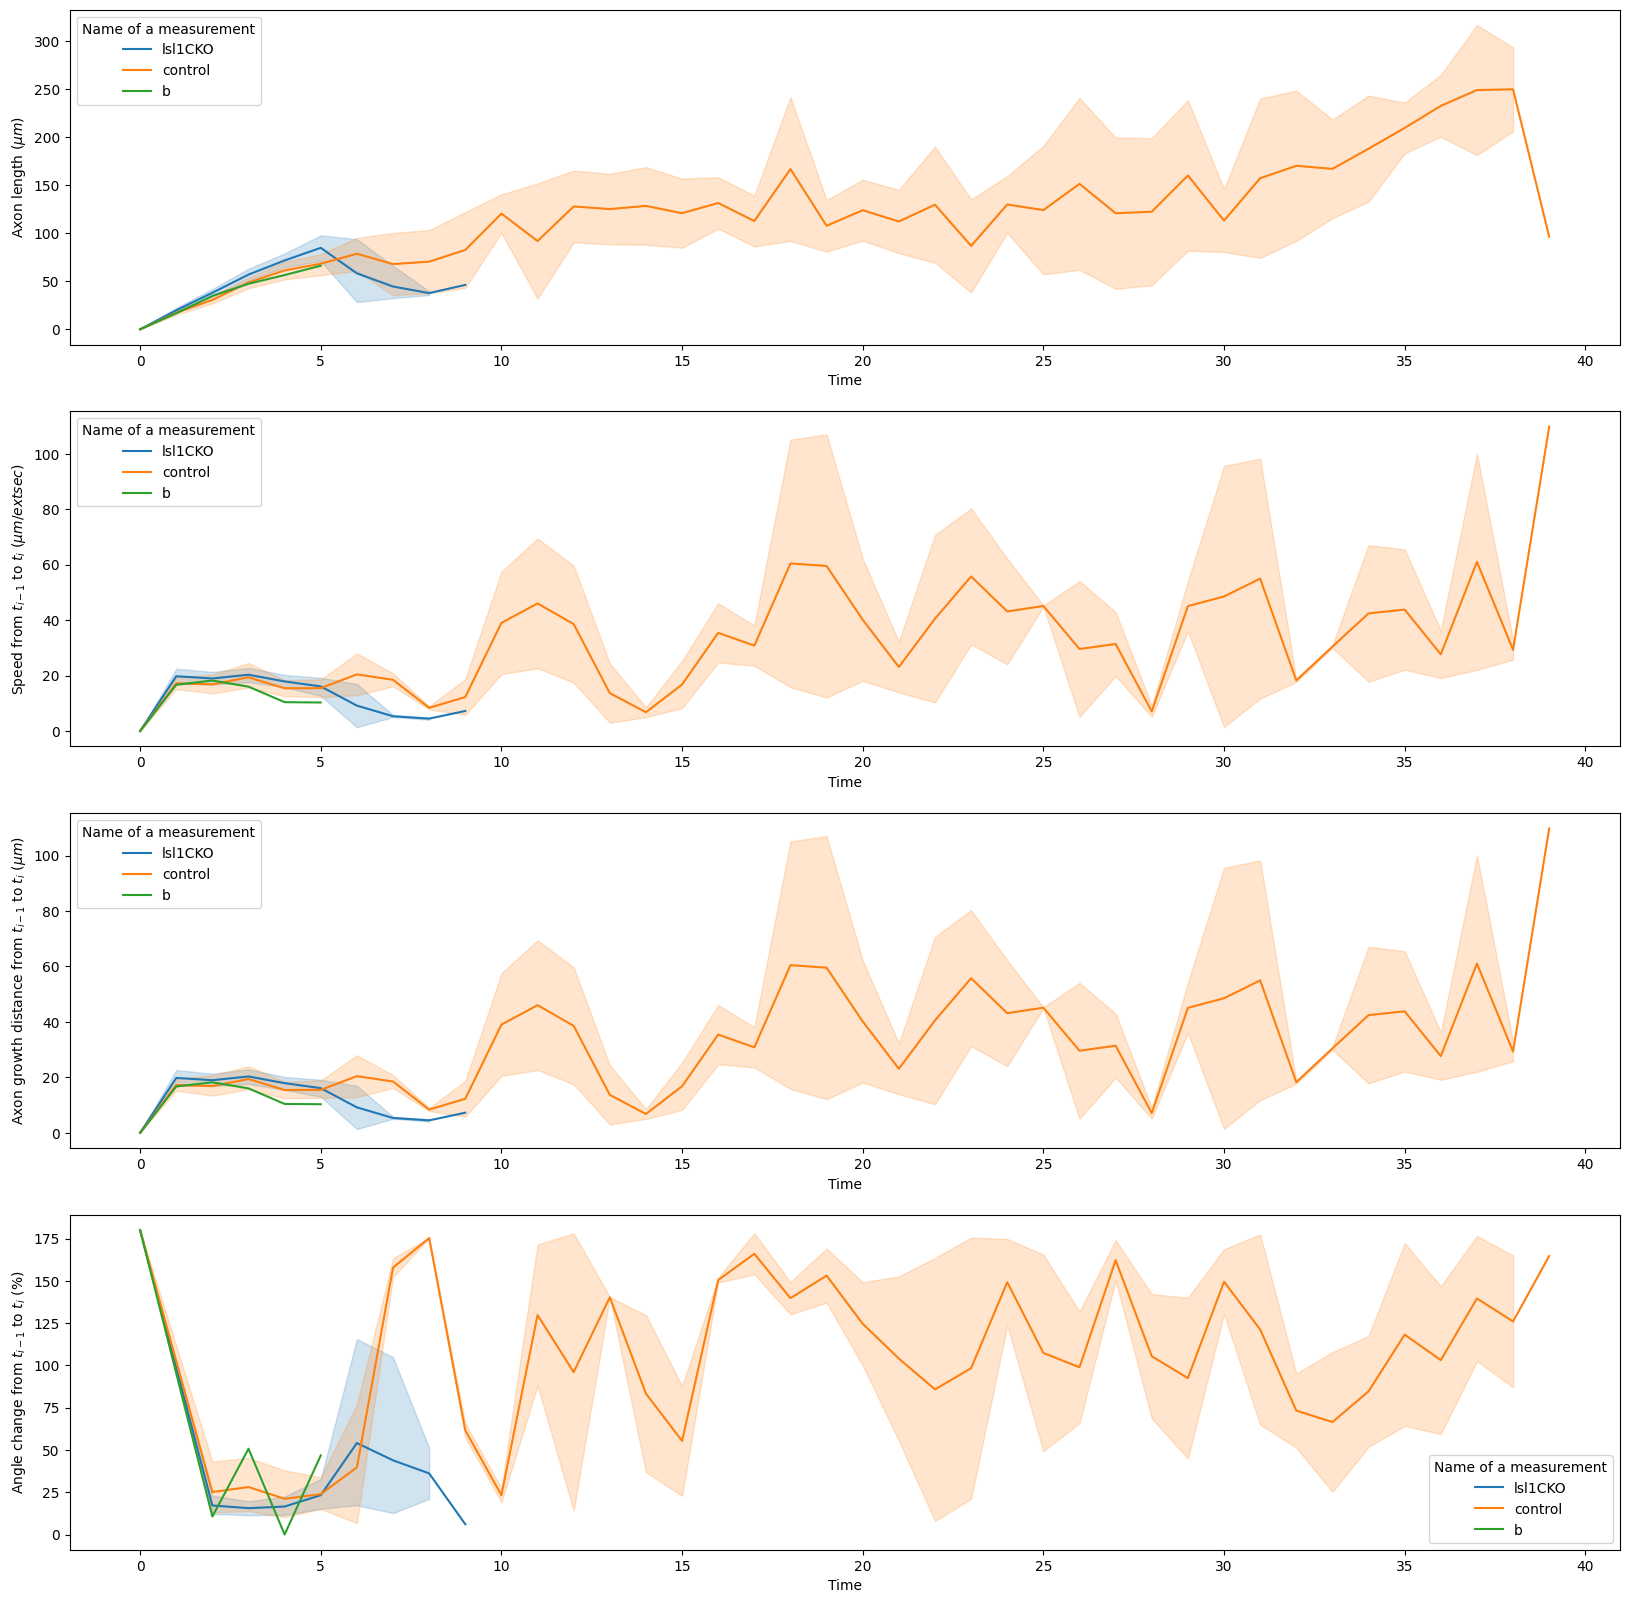

In [21]:
columns_to_show = ['Axon length ($\mu m$)', 'Speed from $t_{i-1}$ to $t_{i}$ ($\mu m / \text{sec}$)',
        'Axon growth distance from $t_{i-1}$ to $t_{i}$ ($\mu m$)',  'Angle change from $t_{i-1}$ to $t_{i}$ (%)']

# visualize all columns in a single plot
fig, ax = plt.subplots(4, 1, figsize=(20, 20))
for i, column in enumerate(columns_to_show):
    sns.lineplot(x=columns[1], y=column, data=measurements, ax=ax[i], hue='Name of a measurement')

In [19]:
measurements

,Name of a measurement,Time,Coordinate of the tip node,Axon length ($\mu m$),Speed from $t_{i-1}$ to $t_{i}$ ($\mu m / \text{sec}$),Axon growth distance from $t_{i-1}$ to $t_{i}$ ($\mu m$),Angle change from $t_{i-1}$ to $t_{i}$ (%),Total growth during all time ($\mu m$),Total speed during all time ($\mu m / \text{sec}$),Total angle change (%)
0,b,0,"[-41.296637000000004, 17.011079999999993]",0.000000,0.000000,0.000000,180.000000,NaN,NaN,NaN
1,b,1,"[-54.054947, 27.754921999999993]",16.679467,16.679467,16.679467,NaN,NaN,NaN,NaN
2,b,2,"[-65.58219300000002, 41.856212]",34.742896,18.213286,18.213286,10.634449,NaN,NaN,NaN
3,b,3,"[-81.58603899999999, 41.856212]",47.334094,16.003846,16.003846,50.735362,NaN,NaN,NaN
4,b,4,"[-91.99413399999999, 41.856211]",56.458097,10.408095,10.408095,0.000006,NaN,NaN,NaN
5,b,5,"[-99.044779, 49.354517000000016]",66.188714,10.292531,10.292531,46.762400,66.188714,11.031452,4.099366
